**THIS CHAPTER IS CURRENTLY UNDER CONSTRUCTION!!!**

(learning)=
# Learning

In the [last chapter](prob-models), we studied general probabilistic models and described several specific and important examples. These descriptions included careful identifications of the parameters of the models, but the question was left open concerning exactly _how_ these parameters are chosen in practice. To cut straight to the chase:

> The goal is to _learn_ the parameters of a model based on an observed dataset.

The actual implementation of a concrete learning procedure is called a _learning algorithm_ by machine learning researchers and engineers, and they will refer to _training_ or _fitting_ a model. Statisticians refer to learning as _parameter estimation_. But no matter what you call them, the values of the parameters that these learning procedures seek are very often solutions to some sort of optimization problem. Intuitively, we want to choose parameters to minimize the "distance" between the model probability distribution and the empirical probability distribution of the dataset:

```{image} ../img/prob-distance.svg
:width: 75%
:align: center
```
&nbsp;

How one precisely defines and measures "distance" (or "discrepancy") is essentially a matter of choosing an objective function to minimize. Some learning algorithms we will study below are actually posed as maximization problems, but these may be reframed as minimization problems via the usual trick of replacing the objective function with its negative.

So, our first goal in this chapter is to describe objective functions for parameter learning. In some form or fashion, all these objectives will involve the data and model probability functions described in {numref}`Chapter %s <prob-models>`, though these functions will be called _likelihood functions_ in this chapter. Thus, all the learning algorithms in this book are _likelihood based_. For some simple models, the solutions to these optimization problems may be obtained in closed form; for others, the gradient-based optimization algorithms that we studied in {numref}`Chapter %s <optim>` are required to obtain approximate solutions.

Our focus in this chapter is using likelihood-based learning algorithms in a framework inspired by machine learning practice; in the chapters that follow, we will turn toward theoretical and statistical properties of likelihood-based parameter estimators in a more traditional statistics-based context.









## Likelihood-based learning objectives

To help motivate likelihood-based learning objectives, let's begin with a simple example. Suppose that we flip a coin $m\geq 1$ times and let $x^{(i)}$ be the number of heads obtained on the $i$-th toss; thus, $x^{(i)}$ is an observed value of a random variable

$$
X \sim \Ber(\theta).
$$

This is a very simple example of a probabilistic graphical model whose underlying graph consists of only two nodes, one for the parameter $\theta$ and one for the (observed) random variable $X$:

```{image} ../img/bern-pgm.svg
:width: 17%
:align: center
```
&nbsp;

Our observations together form a dataset of size $m$:

$$
x^{(1)},\ldots,x^{(m)} \in \{0,1\}.
$$

Based on this dataset, our goal is to _learn_ an optimal value for $\theta$ that minimizes the discrepancy between the model distribution and the empirical distribution of the dataset. To do this, it will be convenient to introduce the sum

$$
\Sigma x \def x^{(1)} + \cdots + x^{(m)}
$$ (sum-dep-eqn)

which counts the total number of heads seen during the $m$ flips of the coin. To make this concrete, suppose that $m=10$ and $\Sigma x=7$, so that we see seven heads over ten flips. Then, intuition suggests that $\theta=0.7$ would be a "more optimal" estimate for the parameter then, say, $\theta=0.1$. Indeed, if $\theta=0.1$, we would expect it highly unlikely to observe seven heads over ten flips when there is only a one-in-ten chance of seeing a head on a single flip.

We may confirm our hunch by actually computing probabilities. Assuming, as always, that the observations in the dataset are independent, we have

$$
p\big(x^{(1)},\ldots,x^{(m)};\theta\big) = \prod_{i=1}^m \theta^{x^{(i)}}(1-\theta)^{1-x^{(i)}} = \theta^x (1-\theta)^{m-\Sigma x}.
$$ (likelihood-bern-eqn)

Notice that the value of the joint mass function depends only on the sum {eq}`sum-dep-eqn`. If this sum is $\Sigma x=7$ and we have $m=10$ and $\theta=0.1$, then

$$
p\big(x^{(1)},\ldots,x^{(m)};\theta=0.1\big) = 0.1^{7} (1-0.1)^{10-7} = 7.29 \times 10^{-8}.
$$

On the other hand, when $\theta=0.7$, we have

$$
p\big(x^{(1)},\ldots,x^{(m)};\theta=0.7\big) = 0.7^{7} (1-0.7)^{10-7} \approx 2.22 \times 10^{-3}.
$$

Thus, it is five orders of magnitude more likely to observe a dataset with $x=7$ for $\theta=0.7$ compared to $\theta=0.1$. In fact, when $\Sigma x=7$ and $m=10$, the value $\theta = 0.7$ is a global maximizer of {eq}`likelihood-bern-eqn` as a function of $\theta$, which may be verified by inspecting the graph:

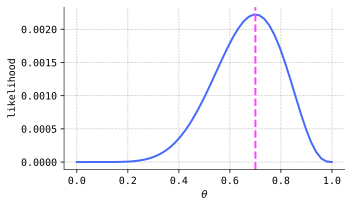

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from itertools import product
import warnings
plt.style.use('../aux-files/custom_style_light.mplstyle')
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
warnings.filterwarnings("ignore")
blue = '#486AFB'
magenta = '#FD46FC'

def likelihood(theta, x, m):
    return (theta ** x) * ((1 - theta) ** (m - x))

m = 10
x = 7
grid = np.linspace(0, 1)
plt.plot(grid, likelihood(grid, x, m))
plt.axvline(x=0.7, color=magenta, linestyle='--')
plt.xlabel('$\\theta$')
plt.ylabel('likelihood')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

```{margin}
**Warning**: Note that the likelihood function $\mathcal{L}(\theta)$ is **not** a probability density function over $\theta$!
```

Note the label along the vertical axis; when the dataset is held fixed, the values of the joint mass function {eq}`likelihood-bern-eqn` as a function of the parameter $\theta$ are referred to as _likelihoods_. This function is called the _data likelihood function_ and is denoted

$$
\mathcal{L}\big(\theta;x^{(1)},\ldots,x^{(m)}\big) = p\big(x^{(1)},\ldots,x^{(m)};\theta\big).
$$

When the dependence of the likelihood function on the dataset does not need to be explicitly indicated, we shall often simply write $\mathcal{L}(\theta)$.

Thus, we see that the parameter $\theta = 0.7$ is a solution to the optimization problem that consists of maximizing the likelihood function $\mathcal{L}(\theta)$. This is a simple example of _maximum likelihood estimation_, or _MLE_.

We see from {eq}`likelihood-bern-eqn` that the data likelihood function is a product of probabilities. Thus, if $m$ is very large, the values of $\mathcal{L}(\theta)$ will be very small. For example, in the case that $m=100$ and $\Sigma x=70$ (which are still quite small values), we get the following plot:

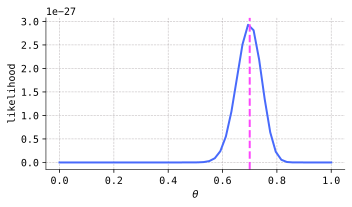

In [2]:
m = 100
x = 70

plt.plot(grid, likelihood(grid, x, m))
plt.axvline(x=0.7, color=magenta, linestyle='--')
plt.xlabel('$\\theta$')
plt.ylabel('likelihood')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

This often leads to difficulties when implementing MLE in computer algorithms due to numerical round-off. The machine is liable to round very small numbers to $0$. For this reason (and others), we often work with the (base-$e$) logarithm of the data likelihood function, denoted by

$$
\ell\big(\theta; x^{(1)},\ldots,x^{(m)}\big) \def \log{\mathcal{L}\big(\theta; x^{(1)},\ldots,x^{(m)}\big)}.
$$

This is called the _data log-likelihood function_. As with the data likelihood function, if the dataset does not need to be explicitly mentioned, we will often write $\ell(\theta)$.

MLE is the optimization problem with the data likelihood function $\mathcal{L}(\theta)$ as the objective function. But it is not hard to prove (see the suggested problems for this section) that the maximizers of the data likelihood function $\mathcal{L}(\theta)$ are the _same_ as the maximizers of the data log-likelihood function $\ell(\theta)$. For our Bernoulli model with $m=100$ and $\Sigma x=70$, a visual comparison of $\mathcal{L}(\theta)$ and $\ell(\theta)$ is given in:

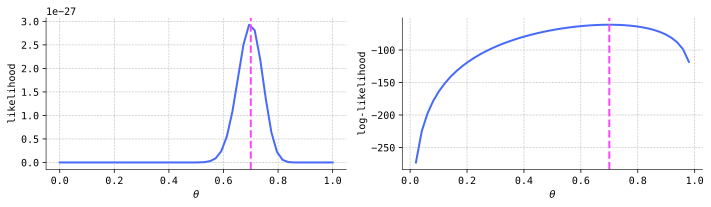

In [3]:
def log_likelihood(theta, x, m):
    return x * np.log(theta) + (m - x) * np.log(1 - theta)

grid = np.linspace(0, 1)
_, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].plot(grid, likelihood(grid, x, m))
axes[1].plot(grid, log_likelihood(grid, x, m))
axes[0].axvline(x=0.7, color=magenta, linestyle='--')
axes[1].axvline(x=0.7, color=magenta, linestyle='--')
axes[0].set_xlabel('$\\theta$')
axes[0].set_ylabel('likelihood')
axes[1].set_xlabel('$\\theta$')
axes[1].set_ylabel('log-likelihood')
plt.tight_layout()

Notice that the values of $\ell(\theta)$ are on a much more manageable scale compared to the values of $\mathcal{L}(\theta)$, and that the two functions have the same global maximizer at $\theta=0.7$.


```{margin}

The acronym _MLE_ often serves double duty: It stands for the procedure of _maximum likelihood estimation_, but it also sometimes stands for the results of this procedure, called _maximum likelihood estimates_.
```

Using the data log-likelihood function as the objective, we may easily compute the MLE in closed form for our Bernoulli model:

```{prf:theorem} MLE for the Bernoulli model, part 1
:label: bern-mle-1-thm

Consider the Bernoulli model described above and suppose that $0 < \Sigma x < m$. The (unique) global maximizer $\theta^\star$ of the data log-likelihood function $\ell(\theta)$ over $\theta \in (0,1)$ is given by $\theta^\star = \Sigma x/m$. Thus, $\theta^\star=\Sigma x/m$ is the maximum likelihood estimate.
```

```{prf:proof}
First note that

$$
\ell(\theta) = \Sigma x \log{\theta} + (m-\Sigma x) \log{(1-\theta)}
$$ (data-log-like-bern-eqn)

from {eq}`likelihood-bern-eqn`.  As you well know, the maximizers of $\ell(\theta)$ over $(0,1)$ must occur at points where $\ell'(\theta)=0$. But

$$
\ell'(\theta) = \frac{\Sigma x}{\theta} - \frac{m-\Sigma x}{1-\theta},
$$

and a little algebra yields the solution $\theta = \Sigma x/m$ to the equation $\ell'(\theta)=0$. To confirm that $\theta = \Sigma x/m$ is a global maximizer over $(0,1)$, note that the second derivatives of both $\log{\theta}$ and $\log{(1-\theta)}$ are always negative, and hence $\ell''(\theta)<0$ as well since $\Sigma x$ and $m-\Sigma x$ are positive (this is a manifestation of [concavity](https://en.wikipedia.org/wiki/Concave_function)). Thus, $\theta^\star = \Sigma x/m$ must be the (unique) global maximizer of $\ell(\theta)$. Q.E.D.
```

Note that the data likelihood function

$$
\mathcal{L}\big(\theta; x^{(1)},\ldots,x^{(m)}\big) = p\big(x^{(1)},\ldots,x^{(m)};\theta\big)
$$

is exactly the _data joint probability function_, in the language of {numref}`Chapter %s <prob-models>`. The latter is the product

$$
p\big(x^{(1)},\ldots,x^{(m)};\theta\big) = \prod_{i=1}^m p\big(x^{(i)};\theta\big)
$$

where

$$
p(x;\theta) = \theta^x (1-\theta)^{1-x}
$$

is the _model probability function_. As a function of $\theta$ with $x$ held fixed, we call

$$
\mathcal{L}(\theta; x) \stackrel{\text{def}}{=} p(\theta; x)
$$

the _model likelihood function_ and

$$
\ell(\theta;x) \stackrel{\text{def}}{=} \log{\mathcal{L}(\theta;x)}
$$

the _model log-likelihood function_. When the data point $x$ does not need to be mentioned explicitly, we will write $\mathcal{L}(\theta)$ and $\ell(\theta)$ in place of $\mathcal{L}(\theta;x)$ and $\ell(\theta;x)$. Note that this clashes with our usage of $\mathcal{L}(\theta)$ and $\ell(\theta)$ to represent the _data_ likelihood and log-likelihood functions when the dataset is not made explicit. You will need to rely on context to clarify which of the two types of likelihood functions (data or model) is meant when we write $\mathcal{L}(\theta)$ or $\ell(\theta)$.

It will be convenient to describe an optimization problem involving the _model_ likelihood function that is equivalent to MLE. Here, _equivalence_ means that the two optimization problems have the same solutions. This new (but equivalent!) optimization problem is appealing in part because it directly uses the empirical probability distribution of the dataset and thus more closely aligns us with the intuitive scheme described in the introduction to this chapter, that the goal of parameter learning is to minimize the "distance" (or "discrepancy") between the model distribution and the empirical distribution. This optimization problem is also useful because it opens the door for the _stochastic gradient descent algorithm_ from {numref}`Chapter %s <optim>` when closed form solutions are not available.

To describe the new optimization problem, let's consider again our Bernoulli model. Let $\hat{p}(x)$ be the empirical mass function of the dataset

$$
x^{(1)},\ldots,x^{(m)} \in \{0,1\}.
$$

Thus, in general we have

$$
\hat{p}(x) = \frac{\text{number of data points $x^{(i)}$ that match $x$}}{m}
$$

for all $x\in \bbr$, but for our particular Bernoulli model, this simplifies to

$$
\hat{p}(0) = \frac{m-\Sigma x}{m} \quad \text{and} \quad \hat{p}(1) = \frac{\Sigma x}{m},
$$

where $\Sigma x=x^{(1)} + \cdots + x^{(m)}$. Letting $\widehat{X}$ be a Bernoulli random variable with $\hat{p}(x)$ as its mass function, we consider the stochastic objective function

$$
J(\theta) \stackrel{\text{def}}{=} E \big( \ell\big(\theta; \widehat{X} \big) \big),
$$

where $\ell(\theta;x)$ is the model log-likelihood function. Note that

$$
J(\theta) = \ell(\theta;1) \hat{p}(1)+ \ell(\theta; 0) \hat{p}(0) = \frac{1}{m} \left[ \Sigma x \log{\theta}  + (m-\Sigma x)\log{(1-\theta)} \right],
$$

and so by comparison with {eq}`data-log-like-bern-eqn` we see that the stochastic objective function $J(\theta)$ differs from the data log-likelihood function $\ell\big( \theta; x^{(1)},\ldots,x^{(m)}\big)$ only by a constant factor of $1/m$. Therefore, MLE is equivalent to the optimization problem with $J(\theta)$ as an objective function, where _equivalence_ means that the two problems have the same solutions. Thus:

```{prf:theorem} MLE for the Bernoulli model, part 2
:label: bern-mle-2-thm

Consider the Bernoulli model described above, suppose that $0 < \Sigma x < m$, and let $\hat{p}(x)$ be the empirical mass function of a dataset. The (unique) maximum likelihood estimate $\theta^\star = \Sigma x/m$ is the global maximizer for the optimization problem with the stochastic objective function

$$
J(\theta) = E \big( \ell\big(\theta; \widehat{X} \big) \big),
$$

where $\ell(\theta;x)$ is the model log-likelihood function and $\widehat{X} \sim \hat{p}(x)$.
```

Then, by combining {prf:ref}`bern-mle-1-thm` and {prf:ref}`bern-mle-2-thm`, we conclude:

```{prf:theorem} Three ways to obtain an MLE
:label: three-mle-thm

The maximum likelihoood estimate for the Bernoulli model may be obtained by maximizing the data likelihood function $\mathcal{L}(\theta)$, the data log-likelihood function $\ell(\theta)$, or the stochastic objective function $J(\theta)$.
```

Our description of likelihood-based learning methods thus far has focused on the simple Bernoulli model. However, from this specific and simple case I am hoping that you can see an outline of a general method able to fit _any_ probabilistic model to data. In particular, _all_ the models we studied in the [previous chapter](prob-models) have model and data likelihood functions, and thus these general methods apply to them.

To be more precise, we need to distinguish between two types of models. The [linear regression](lin-reg-sec), [logistic regression](log-reg-sec), and [neural network models](nn-sec) that we studied in the previous chapter will all be trained as _fully-observed discriminative models_. This means two things: (1) all stochastic nodes in the underlying graphs are observed, and (2) the likelihood functions are obtained from the _conditional_ probability functions of the models. The [Gaussian mixture models](gmm-sec) will be trained as _partially-observed generative models_, which means that the straightfoward MLE algorithm will need to be replaced with the _expectation maximization_ (or _EM_) algorithm. We will address the EM algorithm separately in {numref}`em-gmm-sec` below.

To describe the MLE algorithm for the first type of models, we need to define the likelihood-based objective functions. Note that these functions are all defined in terms of the data and model conditional probability functions from {numref}`prob-models`.

```{prf:definition} MLE training objectives for fully-observed discriminative models
:label: mle-training-objectives-def

Let $\btheta\in \bbr^{k}$ be the parameter vector of a fully-observed discriminative model and let $\hat{p}(\bx,y)$ be the empirical mass function of a dataset

$$
(\bx^{(1)},y^{(1)}),\ldots,(\bx^{(m)},y^{(m)}) \in \bbr^{1\times n} \times \bbr.
$$

1. Define the _data likelihood function_

    $$
    \mathcal{L}\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big) \def p \big(y^{(1)},\ldots,y^{(m)} \mid \bx^{(1)},\ldots,\bx^{(m)}; \ \btheta \big)
    $$

    and the _model likelihood function_

    $$
    \mathcal{L}(\btheta; \ \bx, y) \def p ( y \mid \bx ; \ \btheta) 
    $$

2. Define the _data log-likelihood function_

    $$
    \ell\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big) \def \log{\mathcal{L}\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big)}.
    $$

    and the _model log-likelihood function_

    $$
    \ell(\btheta; \ \bx, y) \def \log{\mathcal{L}(\btheta; \ \bx, y)}.
    $$

3. Define the stochastic objective function

    $$
    J\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big) \def E \big( \ell\big(\btheta; \widehat{\bX}, \widehat{Y}\big) \big),
    $$

    where $(\widehat{\bX}, \widehat{Y}) \sim \hat{p}(\bx, y)$.
```

From independence of the dataset, we obtain the following expressions for these training objectives:

```{prf:theorem} Formulas for MLE training objectives

Let the notation be as in {prf:ref}`mle-training-objectives-def`. We have

$$
\mathcal{L}\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big) = \prod_{i=1}^m \mathcal{L}\big( \btheta;\ \bx^{(i)}, y^{(i)} \big)
$$

and

$$
\ell\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big) = \sum_{i=1}^m \ell\big(\btheta; \ \bx^{(i)}, y^{(i)} \big)
$$ (log-like-simp-eqn)

and

$$
J\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big) = \frac{1}{m} \sum_{i=1}^m \ell\big(\btheta; \ \bx^{(i)}, y^{(i)} \big).
$$ (stochastic-simp-eqn)

```

We now state the MLE algorithm for fully-observed discriminative models; note the similarity to {prf:ref}`three-mle-thm`.

```{prf:definition} Maximum likelihood estimation for fully-observed discriminative models

Let the notation be as in {prf:ref}`mle-training-objectives-def`. A _maximum likelihood estimate_ is a parameter vector $\btheta^\star$ that is a solution to one of the following three equivalent optimization problems:

1. Maximize the data likelihood function

  $$
  \mathcal{L}\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big).
  $$

2. Maximize the data log-likelihood function

  $$
  \ell\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big).
  $$

3. Maximize the stochastic objective function

  $$
  J\big(\btheta; \ \bx^{(1)},\ldots,\bx^{(m)}, y^{(1)},\ldots,y^{(m)}\big).
  $$

```

In practice, nobody ever maximizes the data likelihood function directly; instead, maximum likelihood estimates are obtained via the other two objective functions in the forms {eq}`log-like-simp-eqn` and {eq}`stochastic-simp-eqn`. As we mentiond above, the stochastic objective function has the advantage of allowing the use of stochastic gradient descent when closed form solutions are not available.


















## Maximum likelihood estimation for linear regression models

Linear regression models have the special property that maximum likelihood estimates may be obtained in _closed form_. To derive them, we shall assume---as many books in statistics and machine learning do---that the variance parameter $\sigma^2$ is a _fixed_, _known_ number and does not need to be learned. You will address the case that $\sigma^2$ is unknown in the [suggested problems](https://github.com/jmyers7/stats-book-materials/blob/main/suggested-problems/11-2-suggested-problems.md#problem-3) for this section.

Therefore, the underlying graph of the linear regression model is of the form

```{image} ../img/log-reg-00.svg
:width: 50%
:align: center
```
&nbsp;

where $\bbeta \in \mathbb{R}^{n\times 1}$ and $\beta_0 \in \bbr$ are the only parameters. The link function at $Y$ is still given by

$$
\mu = \bx\bbeta + \beta_0, \quad \text{where} \quad Y \mid \bX ; \ \bbeta,\beta_0 \sim \mathcal{N}(\mu, \sigma^2).
$$

Then, given a dataset

$$
(\bx^{(1)},y^{(1)}),\ldots,(\bx^{(m)},y^{(m)}) \in \bbr^{1\times n} \times \bbr,
$$

we may retrieve the data log-likelihood function from {numref}`lin-reg-sec`:

\begin{align*}
\ell(\bbeta, \beta_0) &= \sum_{i=1}^m \log \left[ \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left(- \frac{1}{2\sigma^2} \big( y^{(i)} - \mu^{(i)} \big)^2 \right) \right] \\
&= - m\log{\sqrt{2\pi\sigma^2}} - \frac{1}{2\sigma^2} \sum_{i=1}^m \big( y^{(i)} - \mu^{(i)}\big)^2,
\end{align*}

where $\mu^{(i)} = \bx^{(i)} \bbeta + \beta_0$ for each $i=1,\ldots,m$.

The maximizers of $\ell(\bbeta,\beta_0)$ will occur at those parameter values for which $\nabla \ell(\bbeta, \beta_0)=0$. Since $-m\log{\sqrt{2\pi\sigma^2}}$ is constant with respect to the parameters, it may be dropped, leaving the equivalent objective function

$$
(\bbeta,\beta_0) \mapsto - \frac{1}{2\sigma^2} \sum_{i=1}^m \big( y^{(i)} - \mu^{(i)}\big)^2.
$$

But the reciprocal variance $1/\sigma^2$ (i.e., the _precision_) is fixed, and so it too may be dropped, leaving us with the equivalent objective function

$$
J(\bbeta,\beta_0) \def - \frac{1}{2}\sum_{i=1}^m \big( y^{(i)} - \mu^{(i)}\big)^2.
$$ (lin-reg-mle-objective-eqn)

Using this latter objective function, we obtain:


```{prf:theorem} Maximum likelihood estimates for linear regression with known variance

Let the notation be as above, and let

$$
\mathcal{X} = \begin{bmatrix}
1 & x^{(1)}_1 & \cdots & x^{(1)}_n \\
\vdots & \vdots & \ddots & \vdots \\
1 & x^{(m)}_1 & \cdots & x^{(m)}_n
\end{bmatrix}, \quad \by = \begin{bmatrix} y^{(1)} \\ \vdots \\ y^{(m)} \end{bmatrix}, \quad \btheta = \begin{bmatrix} \beta_0 \\ \beta_1 \\ \vdots \\ \beta_n \end{bmatrix}
$$

where $\bbeta^T = (\beta_1,\ldots,\beta_n)$. Provided that the $(n+1) \times (n+1)$ square matrix $\mathcal{X}^T \mathcal{X}$ is invertible, the maximum likelihood estimates for the parameters $\bbeta$ and $\beta_0$ are given by

$$
\btheta = \left(\mathcal{X}^T \mathcal{X}\right)^{-1}\mathcal{X}^T \by.
$$
```

```{prf:proof}
As we noted above, the MLEs may be obtained by maximizing the function $J(\btheta)$ given in {eq}`lin-reg-mle-objective-eqn`, which may be rewritten as

$$
J(\btheta) = -\frac{1}{2} \left( \by - \mathcal{X}\btheta\right)^T\left( \by - \mathcal{X}\btheta\right).
$$

But as you will prove in the [suggested problems](https://github.com/jmyers7/stats-book-materials/blob/main/suggested-problems/11-2-suggested-problems.md#problem-1-solution), taking the gradient gives

$$
\nabla J(\btheta) = - \left( \by - \mathcal{X}\btheta\right)^T \text{Jac}\left(\by - \mathcal{X}\btheta \right),
$$

where $\text{Jac}\left(\by - \mathcal{X}\btheta \right)$ is the Jacobian matrix of the function

$$
\bbr^{n+1} \to \bbr^m, \quad \btheta \mapsto \by - \mathcal{X}\btheta.
$$

But it is easy to show that $\text{Jac}\left(\by - \mathcal{X}\btheta \right) = - \mathcal{X}$, and so

$$
\nabla J(\btheta) =  \left( \by - \mathcal{X}\btheta\right)^T \mathcal{X}.
$$

Setting the gradient to zero and solving gives

$$
\mathcal{X}^T \mathcal{X} \btheta = \mathcal{X}^T \by,
$$

from which the desired equation follows. The only thing that is left to prove is that we have actually obtained a _maximizer_. This follows from concavity of the objective function $J(\btheta)$, which you will establish in the [suggested problems](https://github.com/jmyers7/stats-book-materials/blob/main/suggested-problems/11-2-suggested-problems.md#problem-2-solution). Q.E.D.
```


Note that the maximizer of the objective function

$$
J(\bbeta,\beta_0) = - \frac{1}{2} \sum_{i=1}^m \left( y^{(i)} - \mu^{(i)} \right)^2
$$

is the same as the minimizer of the objective function

$$
\text{RSS}(\bbeta, \beta_0) \def \sum_{i=1}^m \left( y^{(i)} - \mu^{(i)} \right)^2,
$$

called the _residual sum of squares_. The name comes about from the terminology introduced in {numref}`lin-reg-sec`, where we learned that the differences

$$
y^{(i)} - \mu^{(i)} = y^{(i)} - \beta_0 - \beta_1 x_1^{(i)} - \cdots - \beta_n x_n^{(i)}
$$

are called the _residuals_. Thus, the maximum likelihood parameter estimates are those that minimize the residual sum of squares, which explains why the MLEs are also often called the _ordinary least squares_ (_OLS_) estimates.



It is worth writing out the MLEs in the case of simple linear regression:

```{prf:corollary} Maximum likelihood estimates for simple linear regression with known variance

Letting the notation be as above, the MLEs for the parameters $\beta_0$ and $\beta_1$ in a simple linear regression model are given by

\begin{align*}
\beta_1 &= \frac{\sum_{i=1}^m \left(x^{(i)} - \bar{x} \right)\left( y^{(i)} - \bar{y} \right)}{\sum_{i=1}^m \left(x^{(i)} - \bar{x} \right)^2}, \\
\beta_0 &= \bar{y} - \beta_1 \bar{x},
\end{align*}

where $\bar{x} = \frac{1}{m} \sum_{i=1}^m x^{(i)}$ and $\bar{y} = \frac{1}{m} \sum_{i=1}^m y^{(i)}$ are the empirical means.
```

```{prf:proof}

First note that

$$
\mathcal{X}^T \mathcal{X} = \begin{bmatrix} m & m \bar{x} \\ m \bar{x} & \sum_{i=1}^m {x^{(i)}}^2 \end{bmatrix}.
$$

Assuming this matrix has nonzero determinant $m \sum_{i=1}^m {x^{(i)}}^2 - m^2 \bar{x}^2\neq 0$, we have

$$
\left(\mathcal{X}^T \mathcal{X} \right)^{-1} = \frac{1}{m \sum_{i=1}^m {x^{(i)}}^2 - m^2 \bar{x}^2} \begin{bmatrix} \sum_{i=1}^m {x^{(i)}}^2 & -m \bar{x} \\ -m \bar{x} & m \end{bmatrix}.
$$

But

$$
\mathcal{X}^T \by = \begin{bmatrix} m \bar{y} \\ \sum_{i=1}^m x^{(i)} y^{(i)} \end{bmatrix},
$$

and so from

$$
\begin{bmatrix} \beta_0 \\ \beta_1 \end{bmatrix} = \btheta =  \left(\mathcal{X}^T \mathcal{X}\right)^{-1}\mathcal{X}^T \by
$$

we conclude

$$
\beta_1 = \frac{\sum_{i=1}^m x^{(i)} y^{(i)} -m \bar{x}\bar{y} }{ \sum_{i=1}^m {x^{(i)}}^2 - m \bar{x}^2}.
$$

But as you may easily check, we have

$$
\sum_{i=1}^m x^{(i)} y^{(i)} -m \bar{x}\bar{y}  = \sum_{i=1}^m \left(x^{(i)} - \bar{x} \right)\left( y^{(i)} - \bar{y} \right)
$$

and

$$
\sum_{i=1}^m {x^{(i)}}^2 - m \bar{x}^2 = \sum_{i=1}^m \left(x^{(i)} - \bar{x} \right)^2,
$$

from which the desired equation for $\beta_1$ follows. To obtain the equation for $\beta_0$, note that

$$
\mathcal{X}^T \mathcal{X} \begin{bmatrix} \beta_0 \\ \beta_1 \end{bmatrix} = \mathcal{X}^T \by 
$$

implies $m \beta_0  + m \beta_1 \bar{x} = m \bar{y}$, and so $\beta_0 = \bar{y} - \beta_1 \bar{x}$. Q.E.D.
```

To illustrate the concepts, let's take a simple toy dataset consisting of the three points

$$
(0, 0), (1, 1), (2, 3) \in \bbr^2.
$$

We may use the formulas above to obtain the MLEs for the two parameters $\beta_0,\beta_1 \in \bbr$. Plotting the regression line $y=\beta_0 + \beta_1 x$ along with the data yields the left-hand plot in what follows, while the contours of the objective function $J(\btheta)$ along with the MLE yield the right-hand plot:

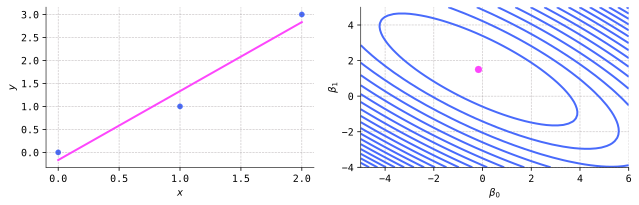

In [4]:
# toy data
X = np.array([[1, 0], [1, 1], [1, 2]])
y = np.array([0, 1, 3]).reshape(-1, 1)

# MLEs for parameters
beta0, beta1 = -1 / 6, 3 / 2

# define objective function
def J(theta, X, y):
    return -0.5 * np.linalg.norm(y - X @ theta, axis=0) ** 2

# define grid
linspace_x = np.linspace(-5, 6)
linspace_y = np.linspace(-4, 5)
x_grid, y_grid = np.meshgrid(linspace_x, linspace_y)
contour_grid = np.column_stack((x_grid.reshape(-1, 1), y_grid.reshape(-1, 1))).T
z = J(contour_grid, X, y).reshape(x_grid.shape)

# plot
_, axes = plt.subplots(ncols=2, figsize=(9, 3))

grid = np.linspace(0, 2)
axes[0].scatter(X[:, 1], y, s=30)
axes[0].plot(grid, beta0 + beta1 * grid, color=magenta)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')

axes[1].contour(x_grid, y_grid, z, levels=20, colors=blue, linestyles='solid')
axes[1].scatter([beta0], [beta1], s=50, color=magenta)
axes[1].set_xlabel('$\\beta_0$')
axes[1].set_ylabel('$\\beta_1$')

plt.tight_layout()

You will compute the maximum likelihood estimates for the parameters $\beta_0$ and $\beta_1$ in the [suggested problems](https://github.com/jmyers7/stats-book-materials/blob/main/suggested-problems/11-2-suggested-problems.md#problem-4).



(em-gmm-sec)=
## Expectation maximization for Gaussian mixture models